In [1]:
import os
print(os.getcwd())  # Shows your current working directory


d:\fraud-detection\notebooks


In [2]:
import pandas as pd
import numpy as np

 
fraud_df = pd.read_csv('../data/raw/Fraud_Data.csv')
ip_df = pd.read_csv('../data/raw/IpAddress_to_Country.csv')
credit_df = pd.read_csv('../data/raw/creditcard.csv')

print(fraud_df.head())
print(ip_df.head())
print(credit_df.head())


   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  
   lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0                16777471  Australia
1              16777472.0                16777727      China


In [3]:
fraud_df.isnull().sum()
credit_df.isnull().sum()

fraud_df = fraud_df.drop_duplicates()
credit_df = credit_df.drop_duplicates()

fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df['age'] = fraud_df['age'].astype(int)


In [4]:
fraud_df['class'].value_counts(normalize=True)
credit_df['Class'].value_counts(normalize=True)


Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64

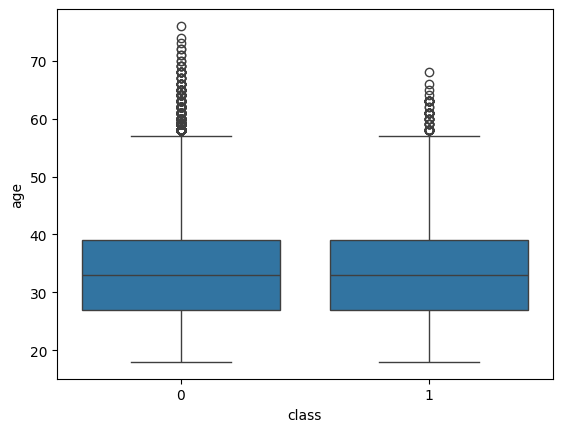

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Age vs Fraud
sns.boxplot(x='class', y='age', data=fraud_df)
plt.show()


In [6]:
import ipaddress

def ip_to_int(ip):
    return int(ipaddress.IPv4Address(ip))

fraud_df['ip_int'] = fraud_df['ip_address'].astype(int)
ip_df['lower_int'] = ip_df['lower_bound_ip_address'].astype(int)
ip_df['upper_int'] = ip_df['upper_bound_ip_address'].astype(int)



In [7]:
import pandas as pd
import numpy as np

# Ensure datetime
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])

# Sort by user and time
fraud_df = fraud_df.sort_values(['user_id', 'purchase_time'])

# --- Step 1: Transaction count in last 24 hours per user ---
# Use groupby + rolling with pd.Grouper
fraud_df['transaction_count_last_24h'] = fraud_df.groupby('user_id', group_keys=False).apply(
    lambda x: x.set_index('purchase_time')
                  .rolling('1d')['user_id']
                  .count()
                  .reset_index(drop=True)
)

# --- Step 2: Time-based features ---
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()

# --- Step 3: One-Hot Encoding categorical features ---
categorical_cols = ['browser', 'sex', 'source', 'country']
existing_cols = [col for col in categorical_cols if col in fraud_df.columns]
fraud_df = pd.get_dummies(fraud_df, columns=existing_cols, drop_first=True)

# --- Step 4: Check final dataframe ---
print(fraud_df.head())


        user_id         signup_time       purchase_time  purchase_value  \
116708        2 2015-01-11 03:47:13 2015-02-21 10:03:37              54   
15108         4 2015-06-02 16:40:57 2015-09-26 21:32:16              41   
46047         8 2015-05-28 07:53:06 2015-08-13 11:53:07              47   
67650         9 2015-05-16 15:58:32 2015-05-20 23:06:42              62   
109067       12 2015-01-10 06:25:12 2015-03-04 20:56:37              35   

            device_id  age    ip_address  class      ip_int  \
116708  FGBQNDNBETFJJ   25  8.802175e+08      0   880217484   
15108   MKFUIVOHLJBYN   38  2.785906e+09      0  2785906106   
46047   SCQGQALXBUQZJ   25  3.560567e+08      0   356056736   
67650   IEZOHXPZBIRTE   21  7.591047e+08      0   759104706   
109067  MSNWCFEHKTIOY   19  2.985180e+09      0  2985180352   

        transaction_count_last_24h  hour_of_day  day_of_week  \
116708                         NaN           10            5   
15108                          1.0        

C:\Users\Hanan\AppData\Local\Temp\ipykernel_10404\4223022828.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fraud_df['transaction_count_last_24h'] = fraud_df.groupby('user_id', group_keys=False).apply(


In [8]:
# Create IntervalIndex
intervals = pd.IntervalIndex.from_arrays(ip_df['lower_int'], ip_df['upper_int'], closed='both')

# Find which interval each IP falls into
indexer = intervals.get_indexer(fraud_df['ip_int'])

# Replace -1 (no match) with NaN
fraud_df['country'] = pd.Series([ip_df['country'].iloc[i] if i != -1 else None for i in indexer])

In [9]:
print(fraud_df['country'].isnull().sum())  # Number of IPs that didn’t match any range



21966


In [10]:
fraud_df['country'].fillna('Unknown', inplace=True)


C:\Users\Hanan\AppData\Local\Temp\ipykernel_10404\657650589.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fraud_df['country'].fillna('Unknown', inplace=True)


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = ['purchase_value', 'age', 'time_since_signup', 'transaction_count_last_24h']
fraud_df[num_cols] = scaler.fit_transform(fraud_df[num_cols])


In [12]:
import sys
print(sys.executable)


c:\Users\Hanan\AppData\Local\Programs\Python\Python313\python.exe


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

 
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])

 plt.figure(figsize=(6,6))
fraud_counts = fraud_df['class'].value_counts()
plt.pie(fraud_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Fraud vs Non-Fraud Transactions')
plt.show()

 
if 'country' in fraud_df.columns:
    fraud_by_country = fraud_df.groupby('country')['class'].mean().sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=fraud_by_country.index, y=fraud_by_country.values, palette='viridis')
    plt.ylabel('Fraud Rate')
    plt.xlabel('Country')
    plt.title('Fraud Rate by Country')
    plt.xticks(rotation=45)
    plt.show()

 
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
plt.figure(figsize=(10,5))
sns.countplot(x='hour_of_day', data=fraud_df, palette='coolwarm')
plt.title('Transactions by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.show()

 
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
plt.figure(figsize=(10,5))
sns.countplot(x='day_of_week', data=fraud_df, palette='magma')
plt.title('Transactions by Day of Week (0=Monday)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Transactions')
plt.show()

 
if 'transaction_count_last_24h' in fraud_df.columns:
    plt.figure(figsize=(10,5))
    sns.histplot(fraud_df['transaction_count_last_24h'], bins=30, kde=True, color='teal')
    plt.title('Transaction Count per User in Last 24 Hours')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Frequency')
    plt.show()

 
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600  # in hours
plt.figure(figsize=(10,6))
sns.boxplot(x='class', y='time_since_signup', data=fraud_df, palette=['skyblue', 'salmon'])
plt.title('Time Since Signup by Transaction Type')
plt.xlabel('Class (0=Non-Fraud, 1=Fraud)')
plt.ylabel('Time Since Signup (Hours)')
plt.ylim(0, 200)  
plt.show()

 
plt.figure(figsize=(12,6))
sns.heatmap(fraud_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

 
numeric_cols = fraud_df.select_dtypes(include=['float64','int64']).columns
plt.figure(figsize=(12,10))
sns.heatmap(fraud_df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


IndentationError: unexpected indent (3483000933.py, line 9)

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = fraud_df.drop('class', axis=1)
y = fraud_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


ModuleNotFoundError: No module named 'imblearn'